In [1]:
!pip install config type
!pip install transitions

  Could not find a version that satisfies the requirement type (from versions: )
No matching distribution found for type
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 71kB 23.4MB/s ta 0:00:01
fastai 1.0.59 requires nvidia-ml-py3, which is not installed.
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import numpy as np
import pandas as pd
import json
import datetime
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import uuid
import os
from os import path
from glob import glob
import json
import re
import pickle
import argparse

import numpy as np
from textwrap import wrap
from scipy import ndimage, misc

#import config
#from type import RecipeContainer, DataContainer
#from utils import url_to_filename

# import matplotlib using agg backend
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt

import boto3
import sagemaker

bucket   = sagemaker.Session().default_bucket() # or replace with your preferred s3 bucket
print(bucket)
prefix   = 'interpret'

users_filename        = 'users.csv'
interactions_filename = 'interactions.csv'
int_exp_filename      = 'interactions_expanded.csv'

NUM_INTERACTIONS = 750000
NUM_USERS        = 30000

SESSION_LEN           = 10
SESSION_DELAY_SECONDS = 2 * 60 # 2 minutes

NUM_SESSIONS = NUM_INTERACTIONS // SESSION_LEN

SECONDS_SINCE_OLDEST_INTERACTION = 60* 60 * 24 * 7 # a week ago
MOST_RECENT_TIMESTAMP = round(datetime.datetime.now().timestamp())

def date_to_string(ts):
    return datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')


sagemaker-us-east-1-111652037296


In [3]:
zip_codes_df = pd.read_csv('zip_codes.csv')
print(zip_codes_df.shape)
zip_codes_df.head()

(100, 3)


,ZIP_CODE,CITY,INCOME
0,79936,El Paso TX,42857
1,90011,Los Angeles CA,23851
2,60629,Chicago IL,40279
3,90650,Norwalk CA,46012
4,90201,Bell Gardens CA,30029


In [4]:
def gen_users(num_users):
    _users = []
    
    _zip_len = zip_codes_df.shape[0]
    
    for i in range(num_users):
        _age        = int(np.random.normal(40, 4))
        _gender_idx = np.random.randint(0, 2)
        _loc_idx    = np.random.randint(0, _zip_len)
        if _gender_idx == 0:
            _gender = 'MALE'
        else:
            _gender = 'FEMALE'
            
        _this_user = [str(i), _age, _gender, 
                      str(zip_codes_df.iloc[_loc_idx][0]), 
                      zip_codes_df.iloc[_loc_idx][2]]
        
        _users.append(_this_user)
        
    _df = pd.DataFrame(_users, columns=['USER_ID', 'AGE', 'GENDER', 'LOCATION', 'SALARY'])
    return _df

users_df = gen_users(NUM_USERS)
print(users_df.shape)
users_df.head()
users_df.to_csv('generated_users.csv', index=False)

(30000, 5)


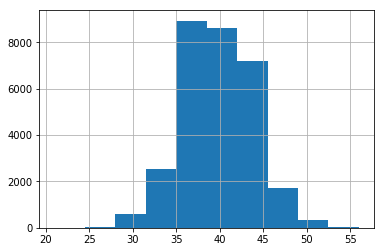

In [5]:
users_df['AGE'].hist()

In [6]:
users_df['LOCATION'].value_counts()[0:10]

11226    344
93033    344
60625    337
77584    335
92804    334
10467    330
10453    329
11206    326
90044    326
11355    325
Name: LOCATION, dtype: int64

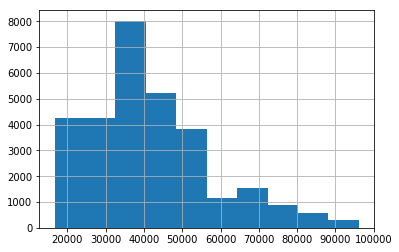

In [7]:
users_df['SALARY'].hist()

In [8]:
def load_recipe(filename):
    """Load a single recipe collection from disk."""
    with open(filename, 'r') as f:
        recipes = json.load(f)
    print('Loaded {:,} recipes from {}'.format(len(recipes), filename))
    return recipes

recipe = load_recipe('recipes/recipes_raw_nosource_ar.json')

Loaded 39,802 recipes from recipes/recipes_raw_nosource_ar.json


In [9]:
i = 0
for key, value in recipe.items():
    print(json.dumps(key, indent=4))
    i += 1
    if (i>10):
        break

"rmK12Uau.ntP510KeImX506H6Mr6jTu"
"5ZpZE8hSVdPk2ZXo1mZTyoPWJRSCPSm"
"clyYQv.CplpwJtjNaFGhx0VilNYqRxu"
"BmqFAmCrDHiKNwX.IQzb0U/v0mLlxFu"
"N.jCksRjB4MFwbgPFQU8Kg.yF.XCtOi"
"kq.naD.8G19M4UU9dVvJgHtpfo.l/eC"
"lYrgWNn00EXblOupzM3tL0jGr9O0CB2"
"Fu0DgGYFUGwc0BBlN6r20o/ihOVs5bO"
"MBRNtqELRRuv8zJH4k7Aba2bmIc2A3C"
"ZPyPoMiNvgAfrKcRpH9FEYV/XsPZBsW"
"ATMxl11LFhuvTbTi9.kX4nhYE50HeJ."


In [11]:
import random, datetime, transitions, uuid
from transitions import MachineError
import datetime

i = 0
s = uuid.uuid1().int>>64        

'''
0 - 'dislike' - Left swipe (Interaction = disliked)
10 - 'open' - Opened (Interaction = opened activity)
20 - 'sharedf' - Shared with friend (Interaction = shared with friend)
30 - 'like' - Right swipe (Interaction = liked)
40 - 'sharedt' - Shared on timeline (Interaction = shared on timeline)
50 - 'sharede' - Shared on external (Interaction = shared on external)
60 - 'addc' - Added content (Interaction = added content)
70 - 'addposcom' - Added positive comment
80 - 'activityc' - Children activity created (Interaction = children activity created)
90 - 'purchased' - Purchased (Interaction = purchased)
100 - 'done' - Done (Interaction = Done, Performed)
'''

# SM1  open --> like --> done
# SM2  open --> like --> purchased --> done
# SM3  open --> dislike
# SM4  open --> like --> done --> sharedf
# SM5  open --> like --> done --> sharedf --> sharede
# SM6  open --> like --> done --> sharedf --> sharede --> addposcom
# SM7  open --> like --> purchased --> done --> sharedf --> sharede --> addposcom 

from transitions import Machine
import random

#SM7  open --> like --> purchased --> done --> sharedf --> sharede --> addposcom 
class SM(object):
    pass
# The states
# And some transitions between states. We're lazy, so we'll leave out
# the inverse phase transitions (freezing, condensation, etc.).
states=['dislike', 'open', 'sharedf', 'like', 'sharedt', 'sharede', 'addc', 'addposcom', 'activityc', 'purchased', 'done']

sm7 = SM()
transitions = [
    { 'trigger': 'next', 'source': 'open', 'dest': 'like' },
    { 'trigger': 'next', 'source': 'like', 'dest': 'purchased' },
    { 'trigger': 'next', 'source': 'purchased', 'dest': 'done' },
    { 'trigger': 'next', 'source': 'done', 'dest': 'sharedf' },
    { 'trigger': 'next', 'source': 'sharedf', 'dest': 'sharede' },
    { 'trigger': 'next', 'source': 'sharede', 'dest': 'addposcom' },
    { 'trigger': 'reset', 'source': '*', 'dest': 'open' }
]
# Initialize
m7 = Machine(sm7, states=states, transitions=transitions, initial='open', ignore_invalid_triggers=False)

# SM1  open --> like --> done

sm1 = SM()
transitions = [
    { 'trigger': 'next', 'source': 'open', 'dest': 'like' },
    { 'trigger': 'next', 'source': 'like', 'dest': 'done' },
    { 'trigger': 'reset', 'source': '*', 'dest': 'open' }
]
# Initialize
m1 = Machine(sm1, states=states, transitions=transitions, initial='open', ignore_invalid_triggers=False)


# SM2  open --> like --> purchased --> done << TODO DSL 
sm2 = SM()
transitions = [
    { 'trigger': 'next', 'source': 'open', 'dest': 'like' },
    { 'trigger': 'next', 'source': 'like', 'dest': 'purchased' },
    { 'trigger': 'next', 'source': 'purchased', 'dest': 'done' },
    { 'trigger': 'reset', 'source': '*', 'dest': 'open' }
]
# Initialize
m2 = Machine(sm2, states=states, transitions=transitions, initial='open', ignore_invalid_triggers=False)

# SM3  open --> dislike
sm3 = SM()
transitions = [
    { 'trigger': 'next', 'source': 'open', 'dest': 'dislike' },
    { 'trigger': 'reset', 'source': '*', 'dest': 'open' }
]
# Initialize
m3 = Machine(sm3, states=states, transitions=transitions, initial='open', ignore_invalid_triggers=False)

# SM4  open --> like --> done --> sharedf
sm4 = SM()
transitions = [
    { 'trigger': 'next', 'source': 'open', 'dest': 'like' },
    { 'trigger': 'next', 'source': 'like', 'dest': 'done' },
    { 'trigger': 'next', 'source': 'done', 'dest': 'sharedf' },
    { 'trigger': 'reset', 'source': '*', 'dest': 'open' }
]
# Initialize
m4 = Machine(sm4, states=states, transitions=transitions, initial='open', ignore_invalid_triggers=False)

# SM5  open --> like --> done --> sharedf --> sharede
sm5 = SM()
transitions = [
    { 'trigger': 'next', 'source': 'open', 'dest': 'like' },
    { 'trigger': 'next', 'source': 'like', 'dest': 'done' },
    { 'trigger': 'next', 'source': 'done', 'dest': 'sharedf' },
    { 'trigger': 'next', 'source': 'sharedf', 'dest': 'sharede' },
    { 'trigger': 'reset', 'source': '*', 'dest': 'open' }
]
# Initialize
m5 = Machine(sm5, states=states, transitions=transitions, initial='open', ignore_invalid_triggers=False)

# SM6  open --> like --> done --> sharedf --> sharede --> addposcom
sm6 = SM()
transitions = [
    { 'trigger': 'next', 'source': 'open', 'dest': 'like' },
    { 'trigger': 'next', 'source': 'like', 'dest': 'done' },    
    { 'trigger': 'next', 'source': 'done', 'dest': 'sharedf' },
    { 'trigger': 'next', 'source': 'sharedf', 'dest': 'addposcom' },
    { 'trigger': 'reset', 'source': '*', 'dest': 'open' }
]
# Initialize
m6 = Machine(sm6, states=states, transitions=transitions, initial='open', ignore_invalid_triggers=False)

# VALUES columns=['USER_ID', 'ITEM_ID', 'EVENT_TYPE',' EVENT_VALUE', 'TIMESTAMP']

user_actions = {
    "dislike":"0",
    "open":"10",
    "sharedf":"20",
    "like":"30",
    "sharedt":"40",
    "sharede":"50",
    "addc":"60",
    "addposcom":"70",
    "activityc":"80",
    "purchased":"90",
    "done":"100"
}

sm_tuple = [sm1, sm2, sm3, sm4, sm5, sm6, sm7]
_interactions = []

for i in range(1, 20000): #Each user users_df.size - use this
#for key, value in recipe.items():
    #_item = key
    #SEED - this is where you control how you generate popular objects
    # Here with sample, we are taking 1 random sample
    user_id = users_df.sample(n=1)['USER_ID'].values[0]
    user_action = random.choice(list(user_actions))
    #item_id = random.choice(list(recipe.items()))[0]
    
    if(i % 5 == 0): #how many parallel sessions? if its 5 then 5 sessions
        session_start_time = (datetime.datetime.now() + datetime.timedelta(minutes=random.randint(1,600))).timestamp()
        
    # Generate popular recipies - by using the same recipes over and over again, controlled introduction  
    
    if (i == 1):
        item_id = random.choice(list(recipe.items()))[0]
    elif (i % 1000 == 0):
        item_id = random.choice(list(recipe.items()))[0]
    
    #State machine loop
    #Select random State Machine 
    
    selected_sm = sm_tuple[random.randrange(len(sm_tuple))]
    timestep_sm = random.randint(1,600)    
    selected_sm.reset()

    while True: 
        try:
            interaction_time_stamp = round((datetime.datetime.now() + datetime.timedelta(minutes=timestep_sm)).timestamp())
            #columns=['USER_ID', 'ITEM_ID', 'EVENT_TYPE',' EVENT_VALUE', 'TIMESTAMP']
            #print('{}, {}, {}, {}, {}'.format(user_id, item_id, selected_sm.state, user_actions[selected_sm.state], interaction_time_stamp))
            _this_interaction = [user_id, item_id, selected_sm.state, user_actions[selected_sm.state], interaction_time_stamp]
            #_this_interaction = [user_id, item_id, interaction_time_stamp]
            
            #print(_this_interaction)
            
            _interactions.append(_this_interaction)
            #choice = random.choice(list(recipe.items()))
            #print(choice[0])
            timestep_sm = timestep_sm + random.randint(1,600)
            selected_sm.next()
        except MachineError as e:
            #print('endstate')
            break
        else:
            continue            
            
_df = pd.DataFrame(_interactions, columns=['USER_ID', 'ITEM_ID', 'EVENT_TYPE', 'EVENT_VALUE', 'TIMESTAMP'])
#_df = pd.DataFrame(_interactions, columns=['USER_ID', 'ITEM_ID', 'TIMESTAMP'])            

In [12]:
import boto3

import json
import numpy as np
import pandas as pd
import time

personalize = boto3.client('personalize')
personalize_runtime = boto3.client('personalize-runtime')

suffix = str(np.random.uniform())[4:9]

bucket = "interpret-" + str(suffix)       # replace with the name of your S3 bucket
filename = "generated_data.csv"

_df.to_csv(filename, index=False)

s3 = boto3.client('s3')
s3.create_bucket(Bucket=bucket)

boto3.Session().resource('s3').Bucket(bucket).Object(filename).upload_file(filename)

In [13]:
schema = {
    "type": "record",
    "name": "Interactions",
    "namespace": "com.amazonaws.personalize.schema",
    "fields": [
        {
            "name": "USER_ID",
            "type": "string"
        },
        {
            "name": "ITEM_ID",
            "type": "string"
        },
        {
            "name": "EVENT_TYPE",
            "type": "string"
        },
        {
            "name": "EVENT_VALUE",
            "type": "float"
        },

        {
            "name": "TIMESTAMP",
            "type": "long"
        }
    ],
    "version": "1.0"
}

create_schema_response = personalize.create_schema(
    name = "interpret-schema" + "-" + str(suffix) ,
    schema = json.dumps(schema)
)

schema_arn = create_schema_response['schemaArn']
print(json.dumps(create_schema_response, indent=2))

{
  "schemaArn": "arn:aws:personalize:us-east-1:111652037296:schema/interpret-schema-04181",
  "ResponseMetadata": {
    "RequestId": "bc70d4eb-8bb7-4a47-a1f5-c94b6c9b122a",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Fri, 27 Mar 2020 00:15:48 GMT",
      "x-amzn-requestid": "bc70d4eb-8bb7-4a47-a1f5-c94b6c9b122a",
      "content-length": "88",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


In [14]:
create_dataset_group_response = personalize.create_dataset_group(
    name = "interpret-dataset-group"  + "-" + str(suffix)
)

dataset_group_arn = create_dataset_group_response['datasetGroupArn']
print(json.dumps(create_dataset_group_response, indent=2))

{
  "datasetGroupArn": "arn:aws:personalize:us-east-1:111652037296:dataset-group/interpret-dataset-group-04181",
  "ResponseMetadata": {
    "RequestId": "f4be1f0e-4a29-4635-91aa-8a4169f044b7",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Fri, 27 Mar 2020 00:15:59 GMT",
      "x-amzn-requestid": "f4be1f0e-4a29-4635-91aa-8a4169f044b7",
      "content-length": "108",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


In [15]:
max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    describe_dataset_group_response = personalize.describe_dataset_group(
        datasetGroupArn = dataset_group_arn
    )
    status = describe_dataset_group_response["datasetGroup"]["status"]
    print("DatasetGroup: {}".format(status))
    
    if status == "ACTIVE" or status == "CREATE FAILED":
        break
        
    time.sleep(60)

DatasetGroup: CREATE PENDING
DatasetGroup: ACTIVE


In [16]:
dataset_type = "INTERACTIONS"
create_dataset_response = personalize.create_dataset(
    name = "interpret-dataset"  + "-" + str(suffix),
    datasetType = dataset_type,
    datasetGroupArn = dataset_group_arn,
    schemaArn = schema_arn
)

dataset_arn = create_dataset_response['datasetArn']
print(json.dumps(create_dataset_response, indent=2))

{
  "datasetArn": "arn:aws:personalize:us-east-1:111652037296:dataset/interpret-dataset-group-04181/INTERACTIONS",
  "ResponseMetadata": {
    "RequestId": "e5d2adf7-3bd7-4bcd-92f6-d6dd033bceed",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Fri, 27 Mar 2020 00:17:00 GMT",
      "x-amzn-requestid": "e5d2adf7-3bd7-4bcd-92f6-d6dd033bceed",
      "content-length": "110",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


In [17]:
s3 = boto3.client("s3")

policy = {
    "Version": "2012-10-17",
    "Id": "PersonalizeS3BucketAccessPolicy",
    "Statement": [
        {
            "Sid": "PersonalizeS3BucketAccessPolicy",
            "Effect": "Allow",
            "Principal": {
                "Service": "personalize.amazonaws.com"
            },
            "Action": [
                "s3:GetObject",
                "s3:ListBucket"
            ],
            "Resource": [
                "arn:aws:s3:::{}".format(bucket),
                "arn:aws:s3:::{}/*".format(bucket)
            ]
        }
    ]
}

s3.put_bucket_policy(Bucket=bucket, Policy=json.dumps(policy))

{'ResponseMetadata': {'RequestId': 'C68164C04B6710DC',
  'HostId': 'v7KHrL5gYKDcNE7ZaiY6AXg2HlYFAIxBECr5gsTYqtDhpYiKYm3F4LLNpTYSN8b6QZQnFypzv1M=',
  'HTTPStatusCode': 204,
  'HTTPHeaders': {'x-amz-id-2': 'v7KHrL5gYKDcNE7ZaiY6AXg2HlYFAIxBECr5gsTYqtDhpYiKYm3F4LLNpTYSN8b6QZQnFypzv1M=',
   'x-amz-request-id': 'C68164C04B6710DC',
   'date': 'Fri, 27 Mar 2020 00:17:01 GMT',
   'server': 'AmazonS3'},
  'RetryAttempts': 0}}

In [18]:
iam = boto3.client("iam")

role_name = "WttyPersonalizeRole"
assume_role_policy_document = {
    "Version": "2012-10-17",
    "Statement": [
        {
          "Effect": "Allow",
          "Principal": {
            "Service": "personalize.amazonaws.com"
          },
          "Action": "sts:AssumeRole"
        }
    ]
}

#create_role_response = iam.create_role(
#    RoleName = role_name,
#    AssumeRolePolicyDocument = json.dumps(assume_role_policy_document)
#)

# AmazonPersonalizeFullAccess provides access to any S3 bucket with a name that includes "personalize" or "Personalize" 
# if you would like to use a bucket with a different name, please consider creating and attaching a new policy
# that provides read access to your bucket or attaching the AmazonS3ReadOnlyAccess policy to the role
#policy_arn = "arn:aws:iam::aws:policy/service-role/AmazonPersonalizeFullAccess"
#iam.attach_role_policy(
#    RoleName = role_name,
#    PolicyArn = policy_arn
#)

#time.sleep(60) # wait for a minute to allow IAM role policy attachment to propagate

#role_arn = create_role_response["Role"]["Arn"]
role_arn = "arn:aws:iam::111652037296:role/WttyPersonalizeRole"
print(role_arn)

arn:aws:iam::111652037296:role/WttyPersonalizeRole


In [19]:
create_dataset_import_job_response = personalize.create_dataset_import_job(
    jobName = "interpret-dataset-import-job" + "-" + str(suffix),
    datasetArn = dataset_arn,
    dataSource = {
        "dataLocation": "s3://{}/{}".format(bucket, filename)
    },
    roleArn = role_arn
)

dataset_import_job_arn = create_dataset_import_job_response['datasetImportJobArn']
print(json.dumps(create_dataset_import_job_response, indent=2))

{
  "datasetImportJobArn": "arn:aws:personalize:us-east-1:111652037296:dataset-import-job/interpret-dataset-import-job-04181",
  "ResponseMetadata": {
    "RequestId": "973a398c-bd0a-486f-a324-d44ff39e4443",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Fri, 27 Mar 2020 00:17:01 GMT",
      "x-amzn-requestid": "973a398c-bd0a-486f-a324-d44ff39e4443",
      "content-length": "122",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


In [20]:
max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    describe_dataset_import_job_response = personalize.describe_dataset_import_job(
        datasetImportJobArn = dataset_import_job_arn
    )
    status = describe_dataset_import_job_response["datasetImportJob"]['status']
    print("DatasetImportJob: {}".format(status))
    
    if status == "ACTIVE" or status == "CREATE FAILED":
        break
        
    time.sleep(10)

DatasetImportJob: CREATE PENDING
DatasetImportJob: CREATE PENDING
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetIm

In [21]:
recipe_arn = "arn:aws:personalize:::recipe/aws-hrnn"

create_solution_response = personalize.create_solution(
    name = "interpret-solution-aws-hrnn" + "-" + str(suffix),
    datasetGroupArn = dataset_group_arn,
    recipeArn = recipe_arn
)

solution_arn = create_solution_response['solutionArn']
print(json.dumps(create_solution_response, indent=2))

create_solution_version_response = personalize.create_solution_version(
    solutionArn = solution_arn
)

solution_version_arn = create_solution_version_response['solutionVersionArn']
print(json.dumps(create_solution_version_response, indent=2))

max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    describe_solution_version_response = personalize.describe_solution_version(
        solutionVersionArn = solution_version_arn
    )
    status = describe_solution_version_response["solutionVersion"]["status"]
    print("SolutionVersion: {}".format(status))
    
    if status == "ACTIVE" or status == "CREATE FAILED":
        break
        
    time.sleep(60)    

{
  "solutionArn": "arn:aws:personalize:us-east-1:111652037296:solution/interpret-solution-aws-hrnn-04181",
  "ResponseMetadata": {
    "RequestId": "592468cb-2344-4313-9be7-7713d3ad621d",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Fri, 27 Mar 2020 00:31:14 GMT",
      "x-amzn-requestid": "592468cb-2344-4313-9be7-7713d3ad621d",
      "content-length": "103",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}
{
  "solutionVersionArn": "arn:aws:personalize:us-east-1:111652037296:solution/interpret-solution-aws-hrnn-04181/85a8613e",
  "ResponseMetadata": {
    "RequestId": "569165c4-f02e-4fa8-b853-6ea6ecaa6abb",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Fri, 27 Mar 2020 00:31:13 GMT",
      "x-amzn-requestid": "569165c4-f02e-4fa8-b853-6ea6ecaa6abb",
      "content-length": "119",
      "connection": "keep-alive"
    },
    "Retr

In [22]:
get_solution_metrics_response = personalize.get_solution_metrics(
    solutionVersionArn = solution_version_arn
)

print(json.dumps(get_solution_metrics_response, indent=2))

create_campaign_response = personalize.create_campaign(
    name = "interpret-campaign-aws-hrnn" + "-" + str(suffix),
    solutionVersionArn = solution_version_arn,
    minProvisionedTPS = 1
)

campaign_arn = create_campaign_response['campaignArn']
print(json.dumps(create_campaign_response, indent=2))

{
  "solutionVersionArn": "arn:aws:personalize:us-east-1:111652037296:solution/interpret-solution-aws-hrnn-04181/85a8613e",
  "metrics": {
    "coverage": 1.0,
    "mean_reciprocal_rank_at_25": 0.9345,
    "normalized_discounted_cumulative_gain_at_10": 0.9948,
    "normalized_discounted_cumulative_gain_at_25": 0.9948,
    "normalized_discounted_cumulative_gain_at_5": 0.9948,
    "precision_at_10": 0.1,
    "precision_at_25": 0.04,
    "precision_at_5": 0.2
  },
  "ResponseMetadata": {
    "RequestId": "a29d372c-c7c9-4ca8-a9c1-d017c094b41e",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Fri, 27 Mar 2020 01:13:17 GMT",
      "x-amzn-requestid": "a29d372c-c7c9-4ca8-a9c1-d017c094b41e",
      "content-length": "406",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}
{
  "campaignArn": "arn:aws:personalize:us-east-1:111652037296:campaign/interpret-campaign-aws-hrnn-04181",
  "ResponseMetadata": {
    "Req

In [23]:
recipe_arn = "arn:aws:personalize:::recipe/aws-hrnn-coldstart"

create_solution_response = personalize.create_solution(
    name = "interpret-solution-aws-hrnn-coldstart" + "-" + str(suffix),
    datasetGroupArn = dataset_group_arn,
    recipeArn = recipe_arn
)

solution_arn = create_solution_response['solutionArn']
print(json.dumps(create_solution_response, indent=2))

create_solution_version_response = personalize.create_solution_version(
    solutionArn = solution_arn
)

solution_version_arn = create_solution_version_response['solutionVersionArn']
print(json.dumps(create_solution_version_response, indent=2))

max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    describe_solution_version_response = personalize.describe_solution_version(
        solutionVersionArn = solution_version_arn
    )
    status = describe_solution_version_response["solutionVersion"]["status"]
    print("SolutionVersion: {}".format(status))
    
    if status == "ACTIVE" or status == "CREATE FAILED":
        break
        
    time.sleep(60)    

InvalidInputException: An error occurred (InvalidInputException) when calling the CreateSolution operation: This recipe requires an ITEMS dataset. Please update your datasetGroup or choose another recipe.

In [24]:
get_solution_metrics_response = personalize.get_solution_metrics(
    solutionVersionArn = solution_version_arn
)

print(json.dumps(get_solution_metrics_response, indent=2))

create_campaign_response = personalize.create_campaign(
    name = "interpret-campaign-aws-hrnn-coldstart" + "-" + str(suffix),
    solutionVersionArn = solution_version_arn,
    minProvisionedTPS = 1
)

campaign_arn = create_campaign_response['campaignArn']
print(json.dumps(create_campaign_response, indent=2))

{
  "solutionVersionArn": "arn:aws:personalize:us-east-1:111652037296:solution/interpret-solution-aws-hrnn-04181/85a8613e",
  "metrics": {
    "coverage": 1.0,
    "mean_reciprocal_rank_at_25": 0.9345,
    "normalized_discounted_cumulative_gain_at_10": 0.9948,
    "normalized_discounted_cumulative_gain_at_25": 0.9948,
    "normalized_discounted_cumulative_gain_at_5": 0.9948,
    "precision_at_10": 0.1,
    "precision_at_25": 0.04,
    "precision_at_5": 0.2
  },
  "ResponseMetadata": {
    "RequestId": "c1cf205c-ec64-4658-a7cf-4c292de237e2",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Fri, 27 Mar 2020 02:29:27 GMT",
      "x-amzn-requestid": "c1cf205c-ec64-4658-a7cf-4c292de237e2",
      "content-length": "406",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}
{
  "campaignArn": "arn:aws:personalize:us-east-1:111652037296:campaign/interpret-campaign-aws-hrnn-coldstart-04181",
  "ResponseMetadata": 

In [ ]:
recipe_arn = "arn:aws:personalize:::recipe/aws-hrnn-metadata"

create_solution_response = personalize.create_solution(
    name = "interpret-solution-aws-hrnn-metadata" + "-" + str(suffix),
    datasetGroupArn = dataset_group_arn,
    recipeArn = recipe_arn
)

solution_arn = create_solution_response['solutionArn']
print(json.dumps(create_solution_response, indent=2))

create_solution_version_response = personalize.create_solution_version(
    solutionArn = solution_arn
)

solution_version_arn = create_solution_version_response['solutionVersionArn']
print(json.dumps(create_solution_version_response, indent=2))

max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    describe_solution_version_response = personalize.describe_solution_version(
        solutionVersionArn = solution_version_arn
    )
    status = describe_solution_version_response["solutionVersion"]["status"]
    print("SolutionVersion: {}".format(status))
    
    if status == "ACTIVE" or status == "CREATE FAILED":
        break
        
    time.sleep(60)    

{
  "solutionArn": "arn:aws:personalize:us-east-1:111652037296:solution/interpret-solution-aws-hrnn-metadata-04181",
  "ResponseMetadata": {
    "RequestId": "4413a956-669c-468d-a98e-b51ec38c5dc7",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Fri, 27 Mar 2020 02:29:27 GMT",
      "x-amzn-requestid": "4413a956-669c-468d-a98e-b51ec38c5dc7",
      "content-length": "112",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}
{
  "solutionVersionArn": "arn:aws:personalize:us-east-1:111652037296:solution/interpret-solution-aws-hrnn-metadata-04181/0da15c97",
  "ResponseMetadata": {
    "RequestId": "64201689-4ccf-412d-8892-b2da8774d17d",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Fri, 27 Mar 2020 02:29:28 GMT",
      "x-amzn-requestid": "64201689-4ccf-412d-8892-b2da8774d17d",
      "content-length": "128",
      "connection": "keep-alive

In [ ]:
get_solution_metrics_response = personalize.get_solution_metrics(
    solutionVersionArn = solution_version_arn
)

print(json.dumps(get_solution_metrics_response, indent=2))

create_campaign_response = personalize.create_campaign(
    name = "interpret-campaign-aws-hrnn-metadata" + "-" + str(suffix),
    solutionVersionArn = solution_version_arn,
    minProvisionedTPS = 1
)

campaign_arn = create_campaign_response['campaignArn']
print(json.dumps(create_campaign_response, indent=2))

In [ ]:
recipe_arn = "arn:aws:personalize:::recipe/aws-personalized-ranking"

create_solution_response = personalize.create_solution(
    name = "interpret-solution-aws-personalized-ranking" + "-" + str(suffix),
    datasetGroupArn = dataset_group_arn,
    recipeArn = recipe_arn
)

solution_arn = create_solution_response['solutionArn']
print(json.dumps(create_solution_response, indent=2))

create_solution_version_response = personalize.create_solution_version(
    solutionArn = solution_arn
)

solution_version_arn = create_solution_version_response['solutionVersionArn']
print(json.dumps(create_solution_version_response, indent=2))

max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    describe_solution_version_response = personalize.describe_solution_version(
        solutionVersionArn = solution_version_arn
    )
    status = describe_solution_version_response["solutionVersion"]["status"]
    print("SolutionVersion: {}".format(status))
    
    if status == "ACTIVE" or status == "CREATE FAILED":
        break
        
    time.sleep(60)    

SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_P

In [ ]:
get_solution_metrics_response = personalize.get_solution_metrics(
    solutionVersionArn = solution_version_arn
)

print(json.dumps(get_solution_metrics_response, indent=2))

create_campaign_response = personalize.create_campaign(
    name = "interpret-campaign-aws-personalized-ranking" + "-" + str(suffix),
    solutionVersionArn = solution_version_arn,
    minProvisionedTPS = 1
)

campaign_arn = create_campaign_response['campaignArn']
print(json.dumps(create_campaign_response, indent=2))

{
  "solutionVersionArn": "arn:aws:personalize:us-east-1:111652037296:solution/interpret-solution-aws-personalized-ranking-04181/a1618c28",
  "metrics": {
    "coverage": 1.2381,
    "mean_reciprocal_rank_at_25": 0.939,
    "normalized_discounted_cumulative_gain_at_10": 0.9969,
    "normalized_discounted_cumulative_gain_at_25": 0.9969,
    "normalized_discounted_cumulative_gain_at_5": 0.9969,
    "precision_at_10": 0.1,
    "precision_at_25": 0.04,
    "precision_at_5": 0.2
  },
  "ResponseMetadata": {
    "RequestId": "1b4e0367-81ac-47a6-ac64-f14e49a35a06",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Fri, 27 Mar 2020 04:15:36 GMT",
      "x-amzn-requestid": "1b4e0367-81ac-47a6-ac64-f14e49a35a06",
      "content-length": "424",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}
{
  "campaignArn": "arn:aws:personalize:us-east-1:111652037296:campaign/interpret-campaign-aws-personalized-ranking-04181"

In [ ]:
recipe_arn = "arn:aws:personalize:::recipe/aws-popularity-count"

create_solution_response = personalize.create_solution(
    name = "interpret-solution-aws-popularity-count" + "-" + str(suffix),
    datasetGroupArn = dataset_group_arn,
    recipeArn = recipe_arn
)

solution_arn = create_solution_response['solutionArn']
print(json.dumps(create_solution_response, indent=2))

create_solution_version_response = personalize.create_solution_version(
    solutionArn = solution_arn
)

solution_version_arn = create_solution_version_response['solutionVersionArn']
print(json.dumps(create_solution_version_response, indent=2))

max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    describe_solution_version_response = personalize.describe_solution_version(
        solutionVersionArn = solution_version_arn
    )
    status = describe_solution_version_response["solutionVersion"]["status"]
    print("SolutionVersion: {}".format(status))
    
    if status == "ACTIVE" or status == "CREATE FAILED":
        break
        
    time.sleep(60)    

{
  "solutionArn": "arn:aws:personalize:us-east-1:111652037296:solution/interpret-solution-aws-popularity-count-04181",
  "ResponseMetadata": {
    "RequestId": "d121109a-3ec2-4281-a94c-b1f4f5fe2f3e",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Fri, 27 Mar 2020 04:15:37 GMT",
      "x-amzn-requestid": "d121109a-3ec2-4281-a94c-b1f4f5fe2f3e",
      "content-length": "115",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}
{
  "solutionVersionArn": "arn:aws:personalize:us-east-1:111652037296:solution/interpret-solution-aws-popularity-count-04181/f5c1b940",
  "ResponseMetadata": {
    "RequestId": "6dc8d76c-fdaa-414e-9301-6e0a77ce16c2",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Fri, 27 Mar 2020 04:15:37 GMT",
      "x-amzn-requestid": "6dc8d76c-fdaa-414e-9301-6e0a77ce16c2",
      "content-length": "131",
      "connection": "keep

In [ ]:
get_solution_metrics_response = personalize.get_solution_metrics(
    solutionVersionArn = solution_version_arn
)

print(json.dumps(get_solution_metrics_response, indent=2))

create_campaign_response = personalize.create_campaign(
    name = "interpret-campaign-aws-popularity-count" + "-" + str(suffix),
    solutionVersionArn = solution_version_arn,
    minProvisionedTPS = 1
)

campaign_arn = create_campaign_response['campaignArn']
print(json.dumps(create_campaign_response, indent=2))

{
  "solutionVersionArn": "arn:aws:personalize:us-east-1:111652037296:solution/interpret-solution-aws-popularity-count-04181/f5c1b940",
  "metrics": {
    "coverage": 1.0,
    "mean_reciprocal_rank_at_25": 0.1962,
    "normalized_discounted_cumulative_gain_at_10": 0.2807,
    "normalized_discounted_cumulative_gain_at_25": 0.403,
    "normalized_discounted_cumulative_gain_at_5": 0.1971,
    "precision_at_10": 0.0521,
    "precision_at_25": 0.04,
    "precision_at_5": 0.0549
  },
  "ResponseMetadata": {
    "RequestId": "babb3627-ae84-42dd-99d3-f23491e8bfa5",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Fri, 27 Mar 2020 04:58:40 GMT",
      "x-amzn-requestid": "babb3627-ae84-42dd-99d3-f23491e8bfa5",
      "content-length": "423",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}
{
  "campaignArn": "arn:aws:personalize:us-east-1:111652037296:campaign/interpret-campaign-aws-popularity-count-04181",
  "

In [ ]:
recipe_arn = "arn:aws:personalize:::recipe/aws-sims"

create_solution_response = personalize.create_solution(
    name = "interpret-solution-aws-sims" + "-" + str(suffix),
    datasetGroupArn = dataset_group_arn,
    recipeArn = recipe_arn
)

solution_arn = create_solution_response['solutionArn']
print(json.dumps(create_solution_response, indent=2))

create_solution_version_response = personalize.create_solution_version(
    solutionArn = solution_arn
)

solution_version_arn = create_solution_version_response['solutionVersionArn']
print(json.dumps(create_solution_version_response, indent=2))

max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    describe_solution_version_response = personalize.describe_solution_version(
        solutionVersionArn = solution_version_arn
    )
    status = describe_solution_version_response["solutionVersion"]["status"]
    print("SolutionVersion: {}".format(status))
    
    if status == "ACTIVE" or status == "CREATE FAILED":
        break
        
    time.sleep(60)    

{
  "solutionArn": "arn:aws:personalize:us-east-1:111652037296:solution/interpret-solution-aws-sims-04181",
  "ResponseMetadata": {
    "RequestId": "909122d2-2d0c-4305-9b02-21b6b750395a",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Fri, 27 Mar 2020 04:58:40 GMT",
      "x-amzn-requestid": "909122d2-2d0c-4305-9b02-21b6b750395a",
      "content-length": "103",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}
{
  "solutionVersionArn": "arn:aws:personalize:us-east-1:111652037296:solution/interpret-solution-aws-sims-04181/b4a30530",
  "ResponseMetadata": {
    "RequestId": "f01503e6-ed6e-46d5-a0ea-a997c0071c03",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Fri, 27 Mar 2020 04:58:40 GMT",
      "x-amzn-requestid": "f01503e6-ed6e-46d5-a0ea-a997c0071c03",
      "content-length": "119",
      "connection": "keep-alive"
    },
    "Retr

In [32]:
get_solution_metrics_response = personalize.get_solution_metrics(
    solutionVersionArn = solution_version_arn
)

print(json.dumps(get_solution_metrics_response, indent=2))

create_campaign_response = personalize.create_campaign(
    name = "interpret-campaign-aws-sims" + "-" + str(suffix),
    solutionVersionArn = solution_version_arn,
    minProvisionedTPS = 1
)

campaign_arn = create_campaign_response['campaignArn']
print(json.dumps(create_campaign_response, indent=2))

{
  "solutionVersionArn": "arn:aws:personalize:us-east-1:111652037296:solution/interpret-solution-aws-sims-04181/b4a30530",
  "metrics": {
    "coverage": 1.0,
    "mean_reciprocal_rank_at_25": 0.0188,
    "normalized_discounted_cumulative_gain_at_10": 0.0251,
    "normalized_discounted_cumulative_gain_at_25": 0.0364,
    "normalized_discounted_cumulative_gain_at_5": 0.0177,
    "precision_at_10": 0.0044,
    "precision_at_25": 0.0035,
    "precision_at_5": 0.0045
  },
  "ResponseMetadata": {
    "RequestId": "de6f977f-1fd9-447e-a057-3e62b7042b63",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Fri, 27 Mar 2020 05:37:43 GMT",
      "x-amzn-requestid": "de6f977f-1fd9-447e-a057-3e62b7042b63",
      "content-length": "414",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}
{
  "campaignArn": "arn:aws:personalize:us-east-1:111652037296:campaign/interpret-campaign-aws-sims-04181",
  "ResponseMetadata": {
